BT Tuần 06

1. Hãy dùng bộ FastText 300d để làm embedding cho model
2. Hãy tìm hiểu cách dùng của convolution 1D trong keras để train mô hình dưới đây
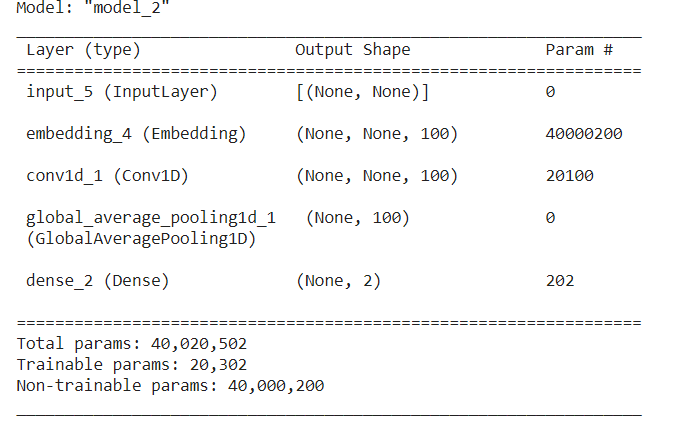

3. Xét 2 trường hợp trainable là True và False trong lớp embedding và đưa ra so sánh

* Lưu ý: Dùng data của bài thực hành số 5 để train 

In [ ]:
import pandas as pd
import numpy as np
import nltk
#đọc data
df = pd.read_csv("https://raw.githubusercontent.com/huynhthanh98/AML/main/lab-04/spam_detection.csv")
df.head()

,Text,Label,y
0,"Go until jurong point, crazy.. Available only ...",ham,0
1,Ok lar... Joking wif u oni...,ham,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam,1
3,U dun say so early hor... U c already then say...,ham,0
4,"Nah I don't think he goes to usf, he lives aro...",ham,0


In [ ]:

nltk.download('punkt')
texts = df["Text"].to_list()
texts = [text.lower() for text in texts ]           # chuyển các đoạn text thành chữ thường (word embedding chỉ cho chữ thường)
tokenized_texts = [nltk.tokenize.word_tokenize(text) for text in texts]    # tách câu thành một list các từ

print(tokenized_texts[0])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
['go', 'until', 'jurong', 'point', ',', 'crazy..', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', '...', 'cine', 'there', 'got', 'amore', 'wat', '...']
